In [1]:
import qubic.toolchain as _tc
import qubic.rpc_client as _rc
import qubitconfig.qchip as _qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt
import chipcalibration.cross_resonance_cal as _cr
from importlib import reload
import qubic.state_disc as _sd
import chipcalibration.config as _cfg
import qubic.job_manager as _jm
import chipcalibration.rabi_experiments as _rabi
from tqdm import tqdm
from scipy.optimize import curve_fit

In [2]:
fpga_config = FPGAConfig(**{'fpga_clk_period': 2.e-9, 'alu_instr_clks': 5, 'jump_cond_clks': 5, 'jump_fproc_clks': 5, 'pulse_regwrite_clks': 3})

qchipname = 'X4Y2'
fpga_config, qchip, channel_config = _cfg.load_configs(qchipname, qchip_file='prior_cr_calibration_jpm.json')

runner = _rc.CircuitRunnerClient(ip='192.168.1.247')
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip)

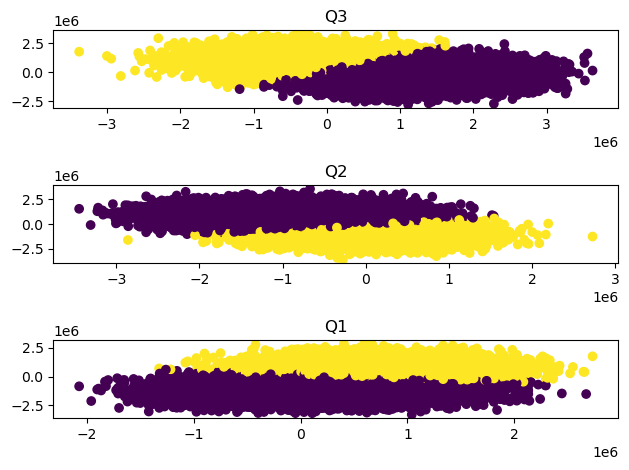

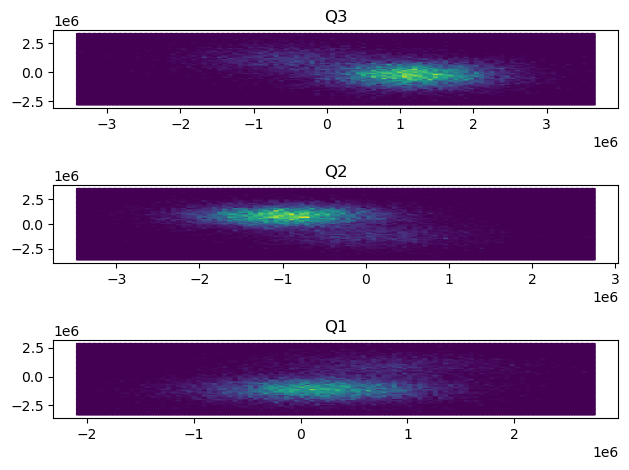

In [3]:
register = ['Q3', 'Q2', 'Q1']
pulse_width_interval = np.linspace(1e-9, 100e-9, 10)

gmm_rabi = _rabi.GMMRabi(register, pulse_width_interval=pulse_width_interval, 
                       channel_configs=channel_config)

gmm_rabi.run_and_report(jm, 1000, qchip)

In [7]:
jobman = _jm.JobManager(fpga_config, channel_config, runner, qchip,
                       gmm_manager=gmm_rabi.gmm_manager)

In [8]:
circuits = []

for axis in ['X', 'Y', 'Z']:
    circ =  [{'name': 'delay', 't': 400.e-6}]
    circ.append({'name': 'X90', 'qubit': [register[0]]})
    circ.append({'name': 'X90', 'qubit': [register[0]]})
    if axis == 'X':
        circ.append({'name': 'Y90', 'qubit': [register[1]]})
        circ.append({'name': 'X90', 'qubit': [register[1]]})
        circ.append({'name': 'X90', 'qubit': [register[1]]})
    elif axis == 'Y':
        circ.append({'name': 'Y90', 'qubit': [register[1]]})
        circ.append({'name': 'X90', 'qubit': [register[1]]})
        circ.append({'name': 'X90', 'qubit': [register[1]]})
    circ.append({'name': 'Z-90', 'qubit': [register[1]]})
    circ.append({'name': 'barrier'})
    circ.append({'name': 'read', 'qubit': [control_qubit]})
    circ.append({'name': 'read', 'qubit': [target_qubit]})
    circuits.append(circ)


In [10]:
shots = jobman.collect_classified_shots(circuits, 1000)